In [47]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch

# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [48]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

# Download and load the training data
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)

# Create a data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


Total number of training images: 60000
Batch size: torch.Size([64, 1, 28, 28])


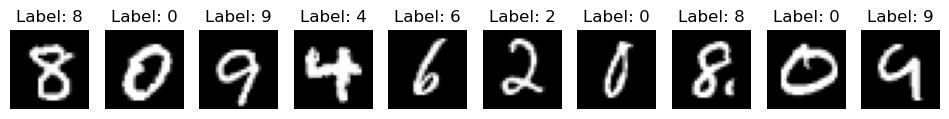

In [49]:
print(f'Total number of training images: {len(train_dataset)}')

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f'Batch size: {images.size()}')

# Plot some images
limit = 10
fig, axes = plt.subplots(1, limit, figsize=(12, 2))
for i in range(limit):
    axes[i].imshow(images[i].numpy().squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {labels[i]}')
    axes[i].axis('off')
plt.show()


In [50]:
def add_noise(img, noise_level):
  """
  Adds Gaussian noise to an image.

  Parameters:
  img (torch.Tensor): Input image tensor.
  noise_level (float): Standard deviation of the Gaussian noise.

  Returns:
  torch.Tensor: Noisy image tensor.
  """
  noise = torch.randn(img.size(), device=device) * noise_level
  img = img.to(device)
  noisy_img = img + noise
  # Clamp the image to be between 0 and 1
  noisy_img = torch.clamp(noisy_img, 0., 1.)
  return noisy_img

In [51]:
def forward_process(img, steps, noise_level):
  """
  Applies the forward process by adding noise iteratively.

  Parameters:
  img (torch.Tensor): Input image tensor.
  steps (int): Number of steps in the forward process.
  noise_level (float): Standard deviation of the Gaussian noise at each step.

  Returns:
  torch.Tensor: Noisy image tensor after all steps.
  """
  noisy_img = img.clone()
  for _ in range(steps):
      noisy_img = add_noise(noisy_img, noise_level)
  return noisy_img

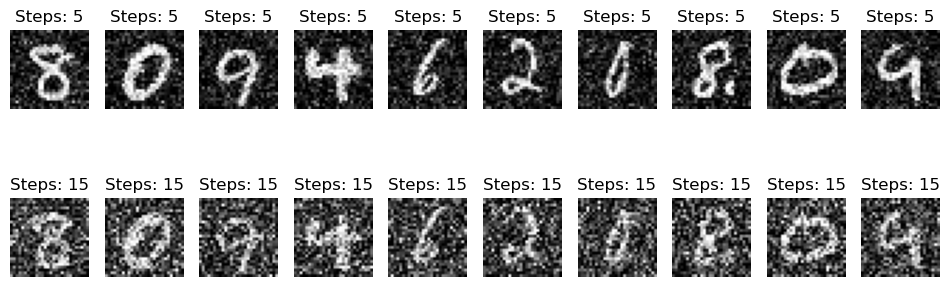

In [52]:
steps_list = [5, 15] # Number of steps in the forward process (How many times to add noise)
noise_level = 0.1

images_limit = 10
fig, axes = plt.subplots(len(steps_list), images_limit, figsize=(12, 4))
for idx, steps in enumerate(steps_list):
  for i in range(images_limit):
    noisy_img = forward_process(images[i], steps, noise_level)
    noisy_img = noisy_img.to('cpu')
    axes[idx, i].imshow(noisy_img.numpy().squeeze(), cmap='gray')
    axes[idx, i].set_title(f'Steps: {steps}')
    axes[idx, i].axis('off')
plt.show()


In [53]:
import torch.nn as nn
import torch.nn.functional as F

class DenoisingNetwork(nn.Module):
  def __init__(self):
    super(DenoisingNetwork, self).__init__()
    # Encoder
    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # Input channels, output channels, kernel size
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    # Decoder
    self.deconv1 = nn.ConvTranspose2d(32, 16, 3, padding=1)
    self.deconv2 = nn.ConvTranspose2d(16, 1, 3, padding=1)

  def forward(self, x):
    # Encoder
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    # Decoder
    x = F.relu(self.deconv1(x))
    x = torch.sigmoid(self.deconv2(x))
    return x


In [54]:
# Instantiate the model, define the loss function and the optimizer
model = DenoisingNetwork().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
noise_level = 0.1

for epoch in range(num_epochs):
  for imgs, _ in train_loader:
    # Add noise to images
    imgs = imgs.to(device)
    noisy_imgs = add_noise(imgs, noise_level)
    # Compute the actual noise
    noise = noisy_imgs - imgs

    # Forward pass
    outputs = model(noisy_imgs)
    loss = criterion(outputs, noise)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/5], Loss: 0.0018
Epoch [2/5], Loss: 0.0016
Epoch [3/5], Loss: 0.0014
Epoch [4/5], Loss: 0.0013
Epoch [5/5], Loss: 0.0015


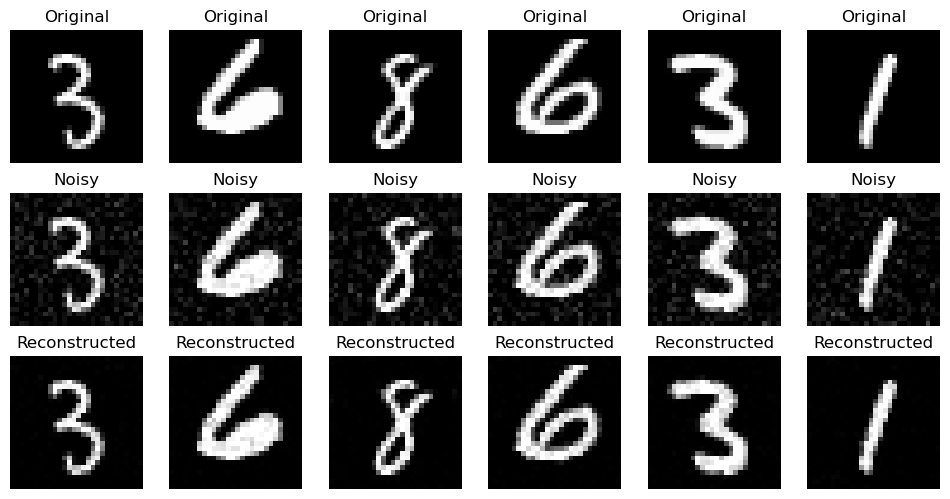

In [55]:
# Denoising test images
test_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=6, shuffle=True)

# Get a batch of test images
test_imgs, _ = next(iter(test_loader))
test_imgs = test_imgs.to(device)
noisy_test_imgs = add_noise(test_imgs, noise_level)

# Use the model to predict the noise
model.eval()
with torch.no_grad():
  predicted_noise = model(noisy_test_imgs)
  reconstructed_imgs = noisy_test_imgs - predicted_noise
  reconstructed_imgs = torch.clamp(reconstructed_imgs, 0., 1.)


# Move tensors back to CPU for visualization
test_imgs = test_imgs.cpu()
noisy_test_imgs = noisy_test_imgs.cpu()
reconstructed_imgs = reconstructed_imgs.cpu()

# Display the results
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
for i in range(6):
  # Original
  axes[0, i].imshow(test_imgs[i].numpy().squeeze(), cmap='gray')
  axes[0, i].set_title('Original')
  axes[0, i].axis('off')
  # Noisy
  axes[1, i].imshow(noisy_test_imgs[i].numpy().squeeze(), cmap='gray')
  axes[1, i].set_title('Noisy')
  axes[1, i].axis('off')
  # Reconstructed
  axes[2, i].imshow(reconstructed_imgs[i].numpy().squeeze(), cmap='gray')
  axes[2, i].set_title('Reconstructed')
  axes[2, i].axis('off')
plt.show()
